# Demo For Face Detection
### BlazeFace (mediapipe/modules/face_detection/face_detection_short_range.tflite)

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import torch
import torchvision as tv

from blaze.face_detection import FaceDetection
from detect_result import DetectResult

Run `face_detection_short_range_map.py` to generate converted pytorch checkpoint.
Once done, you will find `model/face_detection_short_range.pth` and `model/face_detection_short_range.onnx`.

Create a `FaceDetection` object and load checkpoint generated.

In [2]:
FaceDetection.IMAGE_NORMALIZE = True
image_scale = 2

detector = FaceDetection(image_scale=image_scale)
state = torch.load('model/face_detection_short_range.pth', map_location='cpu')
detector.load_state_dict(state, strict=True)

<All keys matched successfully>

Load an image which should be resized to `128x128`. Call detector forward method and it outputs a predicted score vector and a box regressor.

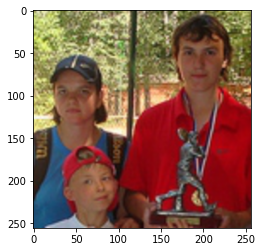

In [3]:
image = tv.io.image.read_image('data/1.jpg')
size = image.shape[1:]
image = tv.transforms.Resize(size=[int(s * image_scale) for s in size]).forward(image)
plt.imshow(image.numpy().transpose([1, 2, 0]))

In [4]:
scores, boxes = detector(image[None])

C:\Users\twytw\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Now you need to perform non-maximum-supression (NMS) to those detected results.
Use the object `DetectResult`.

In [5]:
filter = DetectResult(FaceDetection.NUM_CLASSES, FaceDetection.NUM_COORDS, 0.75, 0.3)
scores, boxes = filter(scores, boxes)

scores = scores.cpu().detach().numpy()
boxes = boxes.cpu().detach().numpy() * 128
print(scores)
print(boxes)

[[0.9210539]
 [0.9128372]
 [0.9047676]]
[[ 98.735344  31.39471   29.899002  29.894648  90.89643   25.271751
  103.70138   24.755106  96.67703   32.762924  97.2055    38.58508
   85.97221   27.660713 111.62086   26.819855]
 [ 25.369125  54.381805  26.412727  26.408337  17.510065  48.55861
   28.99251   47.718746  21.897985  53.906677  22.922373  59.792503
   13.902884  52.046097  38.09076   50.634304]
 [ 35.788902 106.4778    24.341328  24.337107  32.033005 100.95223
   42.709045  98.30678   41.229694 103.630775  41.804935 109.96346
   23.035252 106.88263   45.960915 100.86758 ]]


Now display the result on input image.

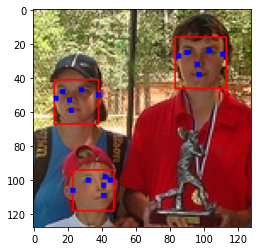

In [6]:
cv_img = cv.imread('data/1.jpg')
for box in boxes:
    box, points = box[:4].reshape([2, 2]), box[4:].reshape([-1, 2])
    lt = box[0] - box[1] / 2
    rb = box[0] + box[1] / 2
    cv_img = cv.rectangle(cv_img, lt.astype('int32'), rb.astype('int32'), color=(0, 0, 255), thickness=1)
    for pts in points:
        cv_img = cv.drawMarker(cv_img, pts.astype('int32'), (255, 0, 0), markerType=2, markerSize=3)
# convert BGR to RGB
plt.figure()
plt.imshow(cv_img[..., ::-1])
plt.show()